In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3178).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3561).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (900).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1148).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (268).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S

In [2]:
!pip install split-folders

In [3]:
import splitfolders
splitfolders.ratio('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone', output="output", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 12446 files [02:36, 79.51 files/s]


**Import Libraries and Setup**

In [4]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Helper function to set random seeds for reproducibility
def set_all_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)



* Importing necessary libraries (PyTorch, torchvision, numpy, etc.)
* A helper function set_all_seeds() is used to ensure reproducibility by setting random seeds for all libraries.



**Define Vision Transformer (ViT) Model**

In [5]:
def get_vit(seed, class_names, device):
    set_all_seeds(seed)
    vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    vit_transforms = vit_weights.transforms()
    vit = torchvision.models.vit_b_16(weights=vit_weights).to(device)
    
    # Freeze the model parameters
    for param in vit.parameters():
        param.requires_grad = False
    
    # Modify the classifier layer
    vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
    
    return vit, vit_transforms



* Vision Transformer (ViT): This function loads a pre-trained ViT model and customizes the final classifier (vit.heads) to match the number of output classes.
* Freezing the parameters in the pretrained layers (except for the classifier) to focus on training only the classifier.


**Train the Model**

In [6]:
import os

def train_model_with_early_stopping(model, train_loader, val_loader, test_loader, device, num_epochs, patience=5):
    """
    Train a model with early stopping and learning rate scheduling.
    
    Parameters:
        model: The neural network to train.
        train_loader: DataLoader for the training set.
        val_loader: DataLoader for the validation set.
        test_loader: DataLoader for the testing set.
        device: The device to train on (CPU or GPU).
        num_epochs: Maximum number of epochs.
        patience: Number of epochs to wait for improvement before stopping early.
    
    Returns:
        train_loss_list: List of training losses per epoch.
        train_acc_list: List of training accuracies per epoch.
        val_acc_list: List of validation accuracies per epoch.
        val_loss_list: List of validation losses per epoch.
    """
    # Optimizer, Scheduler, and Loss
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    
    # Metrics tracking
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
    best_val_loss = float('inf')  # Initial value for best validation loss
    patience_counter = 5         # Counter for early stopping
    best_model_path = 'best_model.pt'

    # Training loop
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        # Training pass
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        # Validation pass
        val_loss, val_acc = evaluate_validation(model, val_loader, criterion, device)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        # Log progress
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)  # Save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping activated after {epoch+1} epochs.")
            break
        
        # Step the scheduler
        scheduler.step()

    # End of training
    print(f"Training complete in {(time.time() - start_time)/60:.2f} minutes")

    # Load the best model for evaluation
    model.load_state_dict(torch.load(best_model_path))
    test_acc = compute_accuracy(model, test_loader, device)
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    # Clean up saved model file
    if os.path.exists(best_model_path):
        os.remove(best_model_path)

    return train_loss_list, train_acc_list, val_acc_list, val_loss_list

def evaluate_validation(model, loader, criterion, device):
    """
    Evaluate the model on the validation dataset.
    
    Parameters:
        model: The model to evaluate.
        loader: DataLoader for the validation/test set.
        criterion: Loss function.
        device: Device to perform computations on.
    
    Returns:
        val_loss: Validation loss.
        val_acc: Validation accuracy.
    """
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(loader)
    val_acc = 100 * correct / total
    return val_loss, val_acc


This function trains the model with a specified number of epochs and tracks the training/validation loss and accuracy.
Uses Stochastic Gradient Descent (SGD) with momentum for optimization and StepLR for learning rate scheduling.
Early Stopping is implemented to stop training when validation loss doesn’t improve for several epochs.

**Evaluation Functions**

In [7]:
# Evaluation function for validation
def evaluate_validation(model, val_loader, criterion, device):
    model.eval()
    correct, total = 0, 0
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    return val_loss, val_acc

# Compute accuracy on a dataset
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total



* Evaluation: These functions evaluate the model on a validation or test set and compute loss and accuracy.
* compute_accuracy() computes the overall accuracy of the model on any dataset (training, validation, or test).



**Plotting the Training and Validation Metrics**

In [8]:
# Function to plot training and validation metrics
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 6))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


This function visualizes the training and validation loss and accuracy over epochs. It provides insights into how well the model is training and whether it's overfitting.

**Load Data and Train the Model**

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 232MB/s]


Epoch [1/30]
Train Loss: 0.3105, Train Acc: 89.35%, Val Loss: 0.1601, Val Acc: 95.65%
Epoch [2/30]
Train Loss: 0.1144, Train Acc: 97.11%, Val Loss: 0.1015, Val Acc: 97.91%
Epoch [3/30]
Train Loss: 0.0799, Train Acc: 98.44%, Val Loss: 0.0709, Val Acc: 98.63%
Epoch [4/30]
Train Loss: 0.0628, Train Acc: 98.93%, Val Loss: 0.0677, Val Acc: 98.55%
Epoch [5/30]
Train Loss: 0.0517, Train Acc: 99.21%, Val Loss: 0.0517, Val Acc: 99.19%
Epoch [6/30]
Train Loss: 0.0426, Train Acc: 99.59%, Val Loss: 0.0491, Val Acc: 99.28%
Epoch [7/30]
Train Loss: 0.0417, Train Acc: 99.63%, Val Loss: 0.0485, Val Acc: 99.52%
Epoch [8/30]
Train Loss: 0.0409, Train Acc: 99.64%, Val Loss: 0.0476, Val Acc: 99.52%
Epoch [9/30]
Train Loss: 0.0406, Train Acc: 99.66%, Val Loss: 0.0478, Val Acc: 99.36%
Epoch [10/30]
Train Loss: 0.0399, Train Acc: 99.66%, Val Loss: 0.0470, Val Acc: 99.28%
Epoch [11/30]
Train Loss: 0.0394, Train Acc: 99.66%, Val Loss: 0.0468, Val Acc: 99.36%
Epoch [12/30]
Train Loss: 0.0391, Train Acc: 99.69%,

<ipython-input-6-0f2ebbb0b66b>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 99.28%


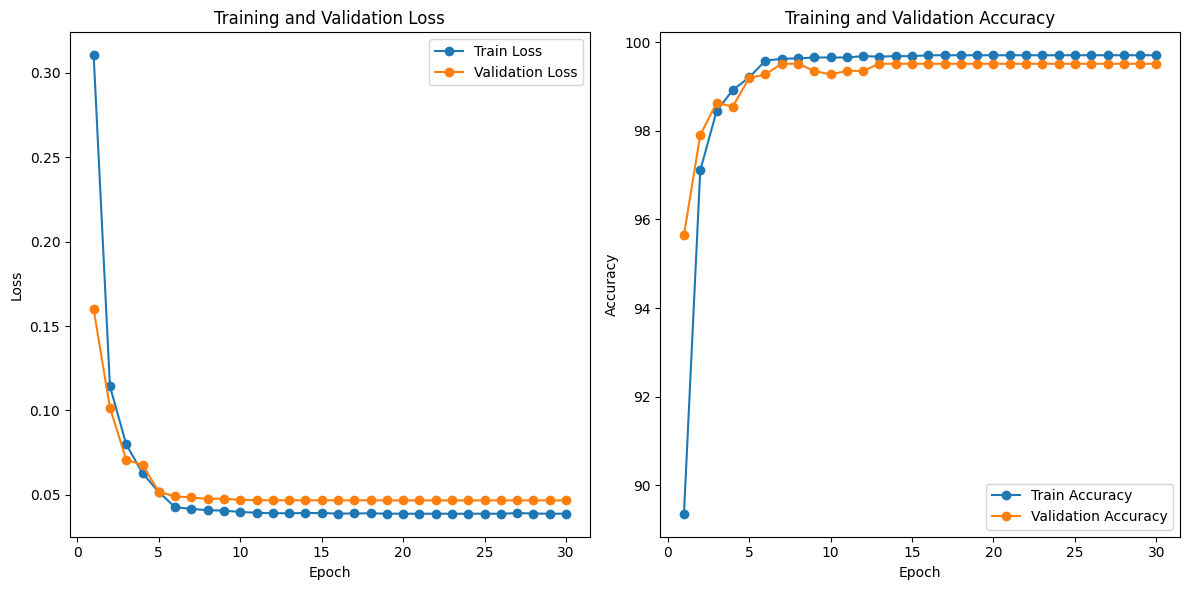

In [9]:
# Define parameters
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 30
batch_size = 32
train_dir = '/kaggle/working/output/train/'
val_dir = '/kaggle/working/output/val/'
test_dir = '/kaggle/working/output/test/'

# Load dataset
transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = datasets.ImageFolder(train_dir, transform=transformers)
val_data = datasets.ImageFolder(val_dir, transform=transformers)
test_data = datasets.ImageFolder(test_dir, transform=transformers)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class_names = train_data.classes
model, transformers = get_vit(42, class_names, DEVICE)

# Train the model and get loss/accuracy values
train_loss, train_acc, val_acc, val_loss = train_model_with_early_stopping(model, train_loader, val_loader, test_loader, DEVICE, num_epochs)

# Plot the metrics including loss
plot_metrics(train_loss, val_loss, train_acc, val_acc)


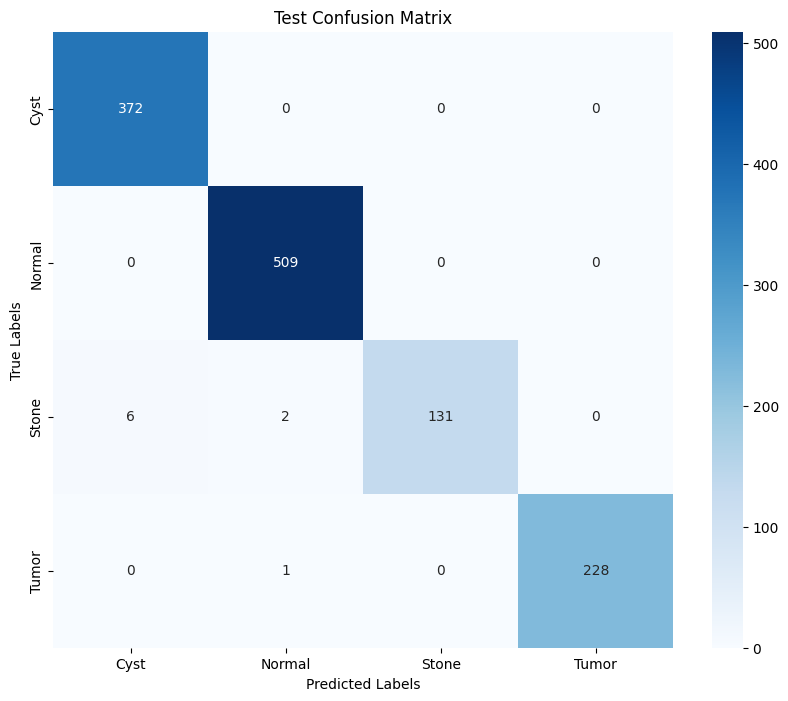

Classification Report:

              precision    recall  f1-score   support

        Cyst       0.98      1.00      0.99       372
      Normal       0.99      1.00      1.00       509
       Stone       1.00      0.94      0.97       139
       Tumor       1.00      1.00      1.00       229

    accuracy                           0.99      1249
   macro avg       0.99      0.98      0.99      1249
weighted avg       0.99      0.99      0.99      1249

Accuracy: 99.28%
Precision (Weighted): 0.9929
Recall (Weighted): 0.9928
F1-Score (Weighted): 0.9927


In [10]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Confusion Matrix for Test Dataset
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report and Metrics
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n")
print(report)

# Overall Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")


In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def compute_overall_auc(model, loader, class_names, device):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.Softmax(dim=1)(outputs)  # Convert logits to probabilities
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    
    # Binarize labels for multi-class AUC
    all_labels_bin = label_binarize(all_labels, classes=np.arange(len(class_names)))
    
    # Calculate macro-average and weighted-average AUC
    macro_auc = roc_auc_score(all_labels_bin, all_probs, average='macro', multi_class='ovr')
    weighted_auc = roc_auc_score(all_labels_bin, all_probs, average='weighted', multi_class='ovr')
    
    print(f"Overall Macro-Average AUC: {macro_auc:.4f}")
    print(f"Overall Weighted-Average AUC: {weighted_auc:.4f}")


In [12]:
compute_overall_auc(model, test_loader, train_data.classes, DEVICE)


Overall Macro-Average AUC: 0.9997
Overall Weighted-Average AUC: 0.9998


In [13]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

def plot_overall_auc(model, loader, class_names, device):
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.Softmax(dim=1)(outputs)  # Convert logits to probabilities
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    
    # Binarize labels for multi-class ROC
    all_labels_bin = label_binarize(all_labels, classes=np.arange(len(class_names)))
    
    # Initialize plot
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'green', 'red', 'orange']  # Colors for each class
    fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}
    
    for i, class_name in enumerate(class_names):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
        plt.plot(fpr_dict[i], tpr_dict[i], color=colors[i], lw=2, 
                 label=f'Class {class_name} (AUC = {roc_auc_dict[i]:.2f})')
    
    # Compute macro-average ROC curve and AUC
    fpr_macro, tpr_macro, _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    plt.plot(fpr_macro, tpr_macro, color='darkviolet', linestyle='--', lw=2, 
             label=f'Macro-Average ROC (AUC = {roc_auc_macro:.2f})')
    
    # Plot settings
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for All Classes')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()


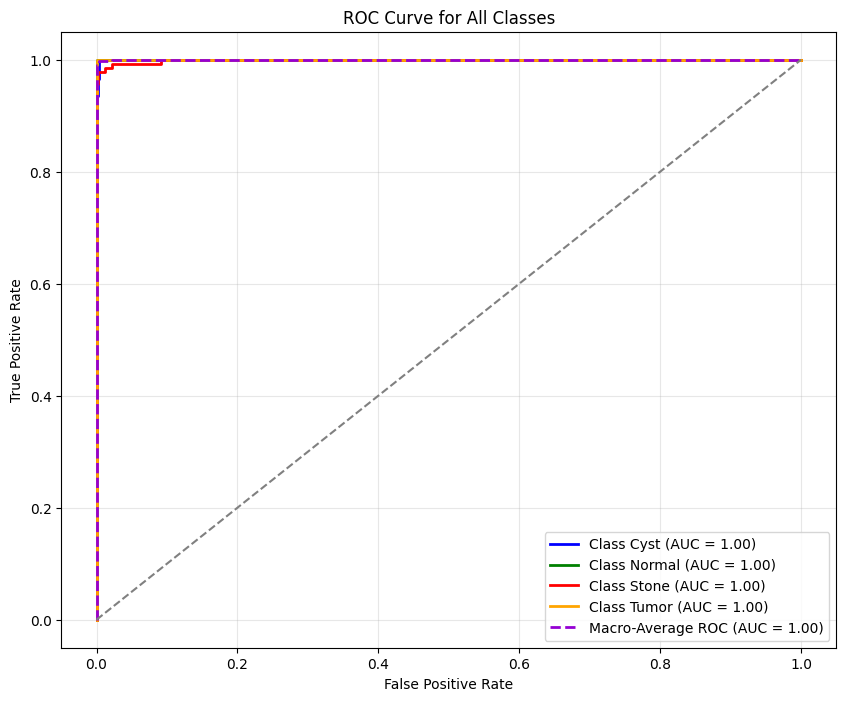

In [14]:
plot_overall_auc(model, test_loader, train_data.classes, DEVICE)


In [15]:
def calculate_metrics(cm, class_names):
    metrics = []
    
    # For each class, calculate TP, TN, FP, FN
    for i, class_name in enumerate(class_names):
        tp = cm[i, i]  # True positives are the diagonal elements
        fn = cm[i, :].sum() - tp  # False negatives are the sum of the row minus TP
        fp = cm[:, i].sum() - tp  # False positives are the sum of the column minus TP
        tn = cm.sum() - (tp + fp + fn)  # True negatives are the sum of all elements minus TP, FP, and FN
        
        metrics.append({
            'Class': class_name,
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn
        })
        
        print(f"Class: {class_name}")
        print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    
    return metrics

# Example usage
def evaluate_and_calculate_metrics(model, loader, class_names, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)
    
    metrics = calculate_metrics(cm, class_names)
    
    # Print the metrics in a more structured way (e.g., as a DataFrame)
    import pandas as pd
    metrics_df = pd.DataFrame(metrics)
    print(metrics_df)
    
    return metrics_df

# Assuming you have already trained the model and have a test loader and class names:
metrics_df = evaluate_and_calculate_metrics(model, test_loader, train_data.classes, DEVICE)


Confusion Matrix:
 [[372   0   0   0]
 [  0 509   0   0]
 [  6   2 131   0]
 [  0   1   0 228]]
Class: Cyst
TP: 372, TN: 871, FP: 6, FN: 0
Class: Normal
TP: 509, TN: 737, FP: 3, FN: 0
Class: Stone
TP: 131, TN: 1110, FP: 0, FN: 8
Class: Tumor
TP: 228, TN: 1020, FP: 0, FN: 1
    Class   TP    TN  FP  FN
0    Cyst  372   871   6   0
1  Normal  509   737   3   0
2   Stone  131  1110   0   8
3   Tumor  228  1020   0   1


In [16]:
from PIL import Image

def predict_single_image(image_path, model, transform, class_names, device):
    """
    Predict the class of a single image.

    Parameters:
        image_path (str): Path to the image file.
        model (torch.nn.Module): Trained model.
        transform (torchvision.transforms): Image preprocessing pipeline.
        class_names (list): List of class names.
        device (torch.device): Device to run the model on.

    Returns:
        predicted_class (str): Predicted class name.
    """
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Example usage:
sample_image_path1 = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (1001).jpg"  # <- Change this to your image path
predicted_class1 = predict_single_image(sample_image_path1, model, transformers, class_names, DEVICE)
print(f"Predicted class for the image '{os.path.basename(sample_image_path1)}': {predicted_class1}")



Predicted class for the image 'Normal- (1001).jpg': Normal


In [17]:
sample_image_path2= "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1007).jpg"
predicted_class2 = predict_single_image(sample_image_path2, model, transformers, class_names, DEVICE)
print(f"Predicted class for the image '{os.path.basename(sample_image_path2)}': {predicted_class2}")

Predicted class for the image 'Tumor- (1007).jpg': Tumor


In [18]:
sample_image_path3= "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1039).jpg"
predicted_class3 = predict_single_image(sample_image_path3, model, transformers, class_names, DEVICE)
print(f"Predicted class for the image '{os.path.basename(sample_image_path3)}': {predicted_class3}")

Predicted class for the image 'Cyst- (1039).jpg': Cyst


In [19]:
sample_image_path4= "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (1012).jpg"
predicted_class4 = predict_single_image(sample_image_path4, model, transformers, class_names, DEVICE)
print(f"Predicted class for the image '{os.path.basename(sample_image_path4)}': {predicted_class4}")

Predicted class for the image 'Stone- (1012).jpg': Stone
